In [103]:
import json

import numpy as np
import matplotlib.pyplot as plt
import nlgeval

In [104]:
NLGEVAL = nlgeval.NLGEval(no_skipthoughts=True, no_glove=True)

In [105]:
def get_min_max_candidates(in_distances, top_n=10):
    sorted_distances = list(sorted(in_distances, key=lambda x: x[1]))
    return {'min': sorted_distances[:top_n], 'max': sorted_distances[-top_n:][::-1]}

In [106]:
def get_candidate_distances(in_predictions):
    distances = []
    for pred in in_predictions:
        scores = list(map(lambda x: x['score'], pred['candidates']))
        if not len(scores):
            distance = None
        else:
            min_score, max_score = min(scores), max(scores)
            distance = abs(max_score - min_score)
        distances.append(distance)
    return distances

In [107]:
def print_prediction(in_prediction):
    print('ID: ', in_prediction['id'])
    print('INPUT:')
    for turn in in_prediction['input']:
        print('{}: {}'.format(turn['side'], turn['utterance']))
    print('TARGET:')
    print(in_prediction['target'])
    print('CANDIDATES:')
    for cand_turn in in_prediction['candidates']:
        print('{} [{}] [{}]'.format(cand_turn['utterance'], cand_turn['score'], cand_turn['method']))

In [108]:
LOG_FILES = ['metalwoz_pure_ext_info_parsed.json', 'metalwoz_pure_ext_info_parsed.json', 'multiwoz_ext_info_parsed.json']

In [109]:
logs = []
for log_file in LOG_FILES:
    with open(log_file) as log_in:
        logs.append(json.load(log_in))

# MetaLWOz pure task

In [110]:
log = logs[0]
distances = get_candidate_distances(log)
non_zero_dist_preds = [(pred, dist) for pred, dist in zip(log, distances) if 1e-7 < abs(dist)]
min_max_preds = get_min_max_candidates(non_zero_dist_preds)
non_zero_distances = [dist for _, dist in non_zero_dist_preds]

In [111]:
print(min(non_zero_distances))
print(max(non_zero_distances))

0.0009999999999998899
16.143


### Number of predictions with identical gen and ret candidates

In [112]:
zero_distances_num = len(distances) - len(non_zero_distances)
print('Identical gen/ret predictions: {} ({:.1f}%)'.format(zero_distances_num,
                                                           100.0 * zero_distances_num / len(distances)))

Identical gen/ret predictions: 16 (0.7%)


### Predictions with 10 closest retrieved/generated pairs

In [113]:
min_preds = min_max_preds['min']
for pred, _ in min_preds:
    print_prediction(pred)
    print('')

ID:  a3cf47bc
INPUT:
Wizard: Hello how may I help you?
User: i'm trying to book rooms
Wizard: for where?
User: I need a few hotel rooms in Tucson
Wizard: how many total rooms?
TARGET:
I need ten rooms
CANDIDATES:
Five rooms [2.794] [generated]
I need 4 rooms on the same floor [2.793] [retrieved]

ID:  2cebd403
INPUT:
Wizard: Hello how may I help you?
User: Want some info about Cyprus.
Wizard: What would you like to know about Cyprus?
TARGET:
What's best time to visit there?
CANDIDATES:
What is the best time to visit? [1.088] [generated]
What is the best time to visit Cyprus? [1.087] [retrieved]

ID:  a40b267c
INPUT:
Wizard: Hello how may I help you?
User: quick question
Wizard: Sure, what would you like to know?
User: where do i go in rome to learn about history?
Wizard: You might want to visit a place called Lou's. It's a museum full of historical artifacts.
User: any other museums?
Wizard: Sure, there is a wonderful art museum Plaza de Art
User: thanks!
Wizard: anything else I can he

### Prediction with the most distant retrieved and generated scores

In [114]:
max_preds = min_max_preds['max']
for pred, _ in max_preds:
    print_prediction(pred)
    print('')

ID:  c9595979
INPUT:
Wizard: Hello how may I help you?
User: I need some tourism help.
Wizard: where would you like to travel to?
User: Montreal. I''m going there this summer. Where are some good spots to go?
Wizard: it depends on how much your are willing ti spent.
User: Well, I'm looking for some festivals in the area around that time. Can you just give me some suggestions?
Wizard: what is your budget?
TARGET:
Budget doesn't matter. I just want to know where I can go.
CANDIDATES:
My budget is $15.00 per ticket. [2.109] [generated]
Great! Thanks so muvh [-14.034] [retrieved]

ID:  7596b1d7
INPUT:
Wizard: Hello how may I help you?
User: Hello. I need to book a flight for two
Wizard: ok where are you going?
User: I will be heading to Hawaii and I need to leave tonight
Wizard: will you be bringing extra luggage?
User: No, I will need first class seats. Money is no object
Wizard: i have 2 tickets for $50,000
User: Okay, that will be fine. Please purchase with my credit card on file
Wizard

### Histogram of distances between the gen/ret candidates' scores

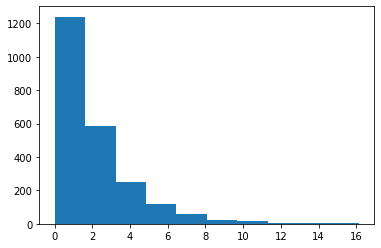

In [115]:
plt.hist(non_zero_distances, bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [116]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [117]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.13775401958052755,
 'Bleu_2': 0.08709841483809297,
 'Bleu_3': 0.06053476737727977,
 'Bleu_4': 0.043493544949373394,
 'METEOR': 0.09700586169517364,
 'ROUGE_L': 0.1249785288608312,
 'CIDEr': 0.339336160363538}

In [118]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.13134569376126987,
 'Bleu_2': 0.08049205082782263,
 'Bleu_3': 0.05600173107632877,
 'Bleu_4': 0.041217311572226585,
 'METEOR': 0.09318854214218383,
 'ROUGE_L': 0.10631682326911585,
 'CIDEr': 0.2712611723902696}

# MetaLWOz cross task

In [119]:
log = logs[1]
distances = get_candidate_distances(log)
non_zero_dist_preds = [(pred, dist) for pred, dist in zip(log, distances) if 1e-7 < abs(dist)]
min_max_preds = get_min_max_candidates(non_zero_dist_preds)
non_zero_distances = [dist for _, dist in non_zero_dist_preds]

In [120]:
print(min(non_zero_distances))
print(max(non_zero_distances))

0.0009999999999998899
16.143


### Number of predictions with identical gen and ret candidates

In [121]:
zero_distances_num = len(distances) - len(non_zero_distances)
print('Identical gen/ret predictions: {} ({:.1f}%)'.format(zero_distances_num,
                                                           100.0 * zero_distances_num / len(distances)))

Identical gen/ret predictions: 16 (0.7%)


### Predictions with 10 closest retrieved/generated pairs

In [122]:
min_preds = min_max_preds['min']
for pred, _ in min_preds:
    print_prediction(pred)
    print('')

ID:  a3cf47bc
INPUT:
Wizard: Hello how may I help you?
User: i'm trying to book rooms
Wizard: for where?
User: I need a few hotel rooms in Tucson
Wizard: how many total rooms?
TARGET:
I need ten rooms
CANDIDATES:
Five rooms [2.794] [generated]
I need 4 rooms on the same floor [2.793] [retrieved]

ID:  2cebd403
INPUT:
Wizard: Hello how may I help you?
User: Want some info about Cyprus.
Wizard: What would you like to know about Cyprus?
TARGET:
What's best time to visit there?
CANDIDATES:
What is the best time to visit? [1.088] [generated]
What is the best time to visit Cyprus? [1.087] [retrieved]

ID:  a40b267c
INPUT:
Wizard: Hello how may I help you?
User: quick question
Wizard: Sure, what would you like to know?
User: where do i go in rome to learn about history?
Wizard: You might want to visit a place called Lou's. It's a museum full of historical artifacts.
User: any other museums?
Wizard: Sure, there is a wonderful art museum Plaza de Art
User: thanks!
Wizard: anything else I can he

### Prediction with the most distant retrieved and generated scores

In [123]:
max_preds = min_max_preds['max']
for pred, _ in max_preds:
    print_prediction(pred)
    print('')

ID:  c9595979
INPUT:
Wizard: Hello how may I help you?
User: I need some tourism help.
Wizard: where would you like to travel to?
User: Montreal. I''m going there this summer. Where are some good spots to go?
Wizard: it depends on how much your are willing ti spent.
User: Well, I'm looking for some festivals in the area around that time. Can you just give me some suggestions?
Wizard: what is your budget?
TARGET:
Budget doesn't matter. I just want to know where I can go.
CANDIDATES:
My budget is $15.00 per ticket. [2.109] [generated]
Great! Thanks so muvh [-14.034] [retrieved]

ID:  7596b1d7
INPUT:
Wizard: Hello how may I help you?
User: Hello. I need to book a flight for two
Wizard: ok where are you going?
User: I will be heading to Hawaii and I need to leave tonight
Wizard: will you be bringing extra luggage?
User: No, I will need first class seats. Money is no object
Wizard: i have 2 tickets for $50,000
User: Okay, that will be fine. Please purchase with my credit card on file
Wizard

### Histogram of distances between the gen/ret candidates' scores

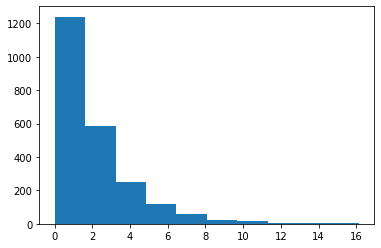

In [124]:
plt.hist(non_zero_distances, bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [125]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [126]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.13775401958052755,
 'Bleu_2': 0.08709841483809297,
 'Bleu_3': 0.06053476737727977,
 'Bleu_4': 0.043493544949373394,
 'METEOR': 0.09700586169517364,
 'ROUGE_L': 0.1249785288608312,
 'CIDEr': 0.339336160363538}

In [127]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.13134569376126987,
 'Bleu_2': 0.08049205082782263,
 'Bleu_3': 0.05600173107632877,
 'Bleu_4': 0.041217311572226585,
 'METEOR': 0.09318854214218383,
 'ROUGE_L': 0.10631682326911585,
 'CIDEr': 0.2712611723902696}

# MultiWOZ

In [128]:
log = logs[2]
distances = get_candidate_distances(log)
non_zero_dist_preds = [(pred, dist) for pred, dist in zip(log, distances) if dist is not None and 1e-7 < abs(dist)]
min_max_preds = get_min_max_candidates(non_zero_dist_preds)
non_zero_distances = [dist for _, dist in non_zero_dist_preds]

In [129]:
print(min(non_zero_distances))
print(max(non_zero_distances))

0.0009999999999998899
16.272


### Number of predictions with identical gen and ret candidates

In [130]:
zero_distances_num = len(distances) - len(non_zero_distances)
print('Identical gen/ret predictions: {} ({:.1f}%)'.format(zero_distances_num,
                                                           100.0 * zero_distances_num / len(distances)))

Identical gen/ret predictions: 1262 (30.2%)


### Predictions with 10 closest retrieved/generated pairs

In [131]:
min_preds = min_max_preds['min']
for pred, _ in min_preds:
    print_prediction(pred)
    print('')

ID:  SNG1282
INPUT:
Wizard: Hello, how may I help you?
User: i want to book a taxi. The taxi should go to saigon city and should arrive by 24:45.
Wizard: Where will you be departing from?
User: I will be departing from parkside pools.
Wizard: I've booked a grey BMW that will leave Parkside Pools, and arrive in Saigon City by 24:45. Their contact
TARGET:
No thank you. that's all.
CANDIDATES:
That is all. Thank you. [2.784] [retrieved]
That is all. Thank you for your help. [2.783] [generated]

ID:  SNG0518
INPUT:
Wizard: Hello, how may I help you?
User: I am looking for a place to dine. The restaurant should be expensive and should serve Chinese food.
Wizard: Would you like the restaurant in a specific place?
TARGET:
Not in any specific area please. I need to book a table for 3 at 14:00 on Saturday.
CANDIDATES:
Do you have the address? [-1.633] [generated]
I am looking for a restaurant in the centre of town, please. [-1.635] [retrieved]

ID:  SNG0900
INPUT:
Wizard: Hello, how may I help 

### Prediction with the most distant retrieved and generated scores

In [132]:
max_preds = min_max_preds['max']
for pred, _ in max_preds:
    print_prediction(pred)
    print('')

ID:  SNG1313
INPUT:
Wizard: Hello, how may I help you?
User: i am looking for a train. The train should leave on Monday and should arrive by 12:45.
Wizard: Where would you like to go?
TARGET:
I would like to depart from Cambridge, and travel to Bishops Stortford.
CANDIDATES:
i would like to go to Cambridge. [5.253] [generated]
I would like to leave after 09:00 on Sunday. [-11.019] [retrieved]

ID:  SNG0223
INPUT:
Wizard: Hello, how may I help you?
User: I've just been robbed and I need some help.
Wizard: I'm sorry to hear that. There is a police station on Parkside, Cambridge CB11JG and the phone number is
TARGET:
No that will be all, thank you.
CANDIDATES:
What is their postcode? [1.339] [retrieved]
I've just been robbed and I need help to find out where to go. 999 999 999 [-13.922] [generated]

ID:  SNG0132
INPUT:
Wizard: Hello, how may I help you?
User: I'm looking for a restaurant in the west side that's in the moderate price range.
Wizard: I have three listings, one for british, i

### Histogram of distances between the gen/ret candidates' scores

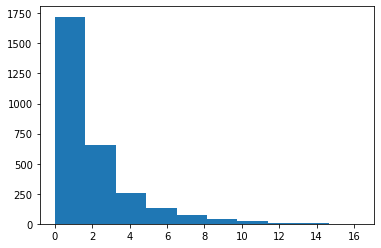

In [133]:
plt.hist(non_zero_distances, bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [134]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [135]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.14955109483649628,
 'Bleu_2': 0.08277910458148781,
 'Bleu_3': 0.05136282278236329,
 'Bleu_4': 0.03196999204230297,
 'METEOR': 0.10814399980936394,
 'ROUGE_L': 0.15344245543239704,
 'CIDEr': 0.2639145591876558}

In [136]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.16155129289626197,
 'Bleu_2': 0.0891345862870597,
 'Bleu_3': 0.05578943546678236,
 'Bleu_4': 0.03536344030926011,
 'METEOR': 0.11407574794797835,
 'ROUGE_L': 0.15155906418256765,
 'CIDEr': 0.2824172075692828}